# Simulated calibration with $C^2$

Calibration of control pulses is the process of fine-tuning parameters in a feedback-loop with the experiment. We will simulate this process here by constructing a black-box simulation and interacting with it exactly like an experiment.

We have manange imports and creation of the black-box the same way as in the previous example in a helper `single_qubit_blackbox_exp.py`.

In [1]:
from single_qubit_blackbox_exp import create_experiment

blackbox = create_experiment()

This blackbox is constructed the same way as in the C1 example. The difference will be in how we interact with it. First, we decide on what experiment we want to perform and need to specify it as a python function. A general, minimal example would be

`def exp_communication(params):
    # Send parameters to experiment controller
    # and recieve a measurement result.
    return measurement_result
 `

Again, `params` is a linear vector of bare numbers. The measurement result can be a single number or a set of results. It can also include additional information about statistics, like averaging, standard deviation, etc.

### ORBIT - Single-length randomized benchmarking
The following defines an [ORBIT](https://arxiv.org/abs/1403.0035) procedure. In short, we define sequences of gates that result in an identity gate if our individual gates are perfect. Any deviation from identity gives us a measure of the imperfections in our gates. Our helper `qt_utils` provides these sequences.

In [2]:
from c3.utils import qt_utils

In [3]:
qt_utils.single_length_RB(
            RB_number=1, RB_length=5,
    )

[['RX90p',
  'RY90p',
  'RY90p',
  'RY90m',
  'RX90p',
  'RY90p',
  'RX90p',
  'RX90p',
  'RX90m',
  'RY90p']]

The desired number of 5 gates is selected from a specific set (the Clifford group) and has to be decomposed into the available gate-set. Here, this means 4 gates per Clifford, hence a sequence of 20 gates.

### Communication with the experiment
Some of the following code is specific to the fact that this a *simulated* calibration. The interface of $C^2$ to the experiment is simple: parameters in $\rightarrow$ results out. Thus, we have to wrap the blackbox by defining the target states and the `opt_map`.

In [4]:
import numpy as np
import tensorflow as tf

def ORBIT_wrapper(p):
    def ORBIT(params, exp, opt_map, qubit_labels, logdir):    
        ### ORBIT meta-parameters ###
        RB_length = 60 # How long each sequence is
        RB_number = 40  # How many sequences
        shots = 1000    # How many averages per readout

        ################################
        ### Simulation specific part ###
        ################################

        do_noise = False  # Whether to add artificial noise to the results

        qubit_label = list(qubit_labels.keys())[0]
        state_labels = qubit_labels[qubit_label]
        state_label = [tuple(l) for l in state_labels]

        # Creating the RB sequences #
        seqs = qt_utils.single_length_RB(
                RB_number=RB_number, RB_length=RB_length
        )

        # Transmitting the parameters to the experiment #
        exp.pmap.set_parameters(params, opt_map)
        exp.set_opt_gates_seq(seqs)

        # Simulating the gates #
        U_dict = exp.compute_propagators()

        # Running the RB sequences and read-out the results #
        pops = exp.evaluate(seqs)
        pop1s, _ = exp.process(pops, labels=state_label)

        results = []
        results_std = []
        shots_nums = []

        # Collecting results and statistics, add noise #
        if do_noise:
            for p1 in pop1s:
                draws = tf.keras.backend.random_binomial(
                    [shots],
                    p=p1[0],
                    dtype=tf.float64,
                )
                results.append([np.mean(draws)])
                results_std.append([np.std(draws)/np.sqrt(shots)])
                shots_nums.append([shots])
        else:
            for p1 in pop1s:
                results.append(p1.numpy())
                results_std.append([0])
                shots_nums.append([shots])

        #######################################
        ### End of Simulation specific part ###
        #######################################

        goal = np.mean(results)
        return goal, results, results_std, seqs, shots_nums
    return ORBIT(
                p, blackbox, gateset_opt_map, state_labels, "/tmp/c3logs/blackbox"
            )

### Optimization
We first import algorithms and the correct optimizer object.

In [5]:
import copy

from c3.experiment import Experiment as Exp
from c3.c3objs import Quantity as Qty
from c3.parametermap import ParameterMap as PMap
from c3.libraries import algorithms, envelopes
from c3.signal import gates, pulse
from c3.optimizers.c2 import C2

### Representation of the experiment within $C^3$
At this point we have to make sure that the gates ("RX90p", etc.) and drive line ("d1") are compatible to the experiment controller operating the blackbox. We mirror the blackbox by creating an experiment in the $C^3$ context:

In [6]:
t_final = 7e-9   # Time for single qubit gates
sideband = 50e6
lo_freq = 5e9 + sideband

 # ### MAKE GATESET
gauss_params_single = {
    'amp': Qty(
        value=0.45,
        min_val=0.4,
        max_val=0.6,
        unit="V"
    ),
    't_final': Qty(
        value=t_final,
        min_val=0.5 * t_final,
        max_val=1.5 * t_final,
        unit="s"
    ),
    'sigma': Qty(
        value=t_final / 4,
        min_val=t_final / 8,
        max_val=t_final / 2,
        unit="s"
    ),
    'xy_angle': Qty(
        value=0.0,
        min_val=-0.5 * np.pi,
        max_val=2.5 * np.pi,
        unit='rad'
    ),
    'freq_offset': Qty(
        value=-sideband - 0.5e6,
        min_val=-53 * 1e6,
        max_val=-47 * 1e6,
        unit='Hz 2pi'
    ),
    'delta': Qty(
        value=-1,
        min_val=-5,
        max_val=3,
        unit=""
    )
}

gauss_env_single = pulse.Envelope(
    name="gauss",
    desc="Gaussian comp for single-qubit gates",
    params=gauss_params_single,
    shape=envelopes.gaussian_nonorm
)
nodrive_env = pulse.Envelope(
    name="no_drive",
    params={
        't_final': Qty(
            value=t_final,
            min_val=0.5 * t_final,
            max_val=1.5 * t_final,
            unit="s"
        )
    },
    shape=envelopes.no_drive
)
carrier_parameters = {
    'freq': Qty(
        value=lo_freq,
        min_val=4.5e9,
        max_val=6e9,
        unit='Hz 2pi'
    ),
    'framechange': Qty(
        value=0.0,
        min_val= -np.pi,
        max_val= 3 * np.pi,
        unit='rad'
    )
}
carr = pulse.Carrier(
    name="carrier",
    desc="Frequency of the local oscillator",
    params=carrier_parameters
)

RX90p = gates.Instruction(
    name="RX90p",
    t_start=0.0,
    t_end=t_final,
    channels=["d1"]
)
QId = gates.Instruction(
    name="Id",
    t_start=0.0,
    t_end=t_final,
    channels=["d1"]
)

RX90p.add_component(gauss_env_single, "d1")
RX90p.add_component(carr, "d1")
QId.add_component(nodrive_env, "d1")
QId.add_component(copy.deepcopy(carr), "d1")
QId.comps['d1']['carrier'].params['framechange'].set_value(
    (-sideband * t_final * 2 * np.pi) % (2*np.pi)
)
RY90p = copy.deepcopy(RX90p)
RY90p.name = "RY90p"
RX90m = copy.deepcopy(RX90p)
RX90m.name = "RX90m"
RY90m = copy.deepcopy(RX90p)
RY90m.name = "RY90m"
RY90p.comps['d1']['gauss'].params['xy_angle'].set_value(0.5 * np.pi)
RX90m.comps['d1']['gauss'].params['xy_angle'].set_value(np.pi)
RY90m.comps['d1']['gauss'].params['xy_angle'].set_value(1.5 * np.pi)

parameter_map = PMap(instructions=[QId, RX90p, RY90p, RX90m, RY90m])

# ### MAKE EXPERIMENT
exp = Exp(pmap=parameter_map)

Next, we define the parameters we whish to calibrate. See how these gate instructions are defined in the experiment setup example or in `single_qubit_blackbox_exp.py`. Our gate-set is made up of 4 gates, rotations of 90 degrees around the $x$ and $y$-axis in positive and negative direction. While it is possible to optimize each parameters of each gate individually, in this example all four gates share parameters. They only differ in the phase $\phi_{xy}$ that is set in the definitions.

In [7]:
gateset_opt_map =   [
    [
      ("RX90p", "d1", "gauss", "amp"),
      ("RY90p", "d1", "gauss", "amp"),
      ("RX90m", "d1", "gauss", "amp"),
      ("RY90m", "d1", "gauss", "amp")
    ],
    [
      ("RX90p", "d1", "gauss", "delta"),
      ("RY90p", "d1", "gauss", "delta"),
      ("RX90m", "d1", "gauss", "delta"),
      ("RY90m", "d1", "gauss", "delta")
    ],
    [
      ("RX90p", "d1", "gauss", "freq_offset"),
      ("RY90p", "d1", "gauss", "freq_offset"),
      ("RX90m", "d1", "gauss", "freq_offset"),
      ("RY90m", "d1", "gauss", "freq_offset")
    ],
    [
      ("Id", "d1", "carrier", "framechange")
    ]
  ]

parameter_map.set_opt_map(gateset_opt_map)

As defined above, we have 16 parameters where 4 share their numerical value. This leaves 4 values to optimize.

In [8]:
parameter_map.print_parameters()

RX90p-d1-gauss-amp                     : 450.000 mV 
RY90p-d1-gauss-amp
RX90m-d1-gauss-amp
RY90m-d1-gauss-amp

RX90p-d1-gauss-delta                   : -1.000  
RY90p-d1-gauss-delta
RX90m-d1-gauss-delta
RY90m-d1-gauss-delta

RX90p-d1-gauss-freq_offset             : -50.500 MHz 2pi 
RY90p-d1-gauss-freq_offset
RX90m-d1-gauss-freq_offset
RY90m-d1-gauss-freq_offset

Id-d1-carrier-framechange             : 4.084 rad 



It is important to note that in this example, we are transmitting only these four parameters to the experiment. We don't know how the blackbox will implement the pulse shapes and care has to be taken that the parameters are understood on the other end. Optionally, we could specifiy a virtual AWG within $C^3$ and transmit pixilated pulse shapes directly to the physiscal AWG.

### Algorithms
As an optimization algoritm, we choose [CMA-Es](https://en.wikipedia.org/wiki/CMA-ES) and set up some options specific to this algorithm.

#### Maximum Evaluations
We set the maximum number of evaluations to 30 for quick demonstration. Ideally around 250 function evaluations are useful for a good optimization.

In [9]:
alg_options = {
    "popsize" : 10,
    "maxfevals" : 30,
    "init_point" : "True",
    "tolfun" : 0.01,
    "spread" : 0.25
  }

We define the subspace as both excited states $\{|1>,|2>\}$, assuming read-out can distinguish between 0, 1 and 2.

In [10]:
state_labels = {
      "excited" : [(1,), (2,)]
  }

In the real world, this setup needs to be handled in the experiment controller side.
We construct the optimizer object with the options we setup:

In [11]:
import os
import tempfile

# Create a temporary directory to store logfiles, modify as needed
log_dir = os.path.join(tempfile.TemporaryDirectory().name, "c3logs")

opt = C2(
    dir_path=log_dir,
    run_name="ORBIT_cal",
    eval_func=ORBIT_wrapper,
    pmap=parameter_map,
    exp_right=exp,
    algorithm=algorithms.cmaes,
    options=alg_options
)

And run the calibration:

In [12]:
x = parameter_map.get_parameters_scaled()

In [13]:
opt.optimize_controls()

C3:STATUS:Saving as: /var/folders/dy/n5f7y8ms3137bqhcms4jx2nw0000gn/T/tmpyp2z4d6f/c3logs/ORBIT_cal/2021_02_02_T_20_32_32/calibration.log
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 4 (seed=349247, Tue Feb  2 20:32:32 2021)
C3:STATUS:Adding initial point to CMA sample.
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 1.391907999386434e-01 1.0e+00 1.97e-01  2e-01  2e-01 0:46.5
    2     20 2.455478666186154e-01 1.3e+00 1.88e-01  1e-01  2e-01 1:29.9
    3     30 1.562929867626229e-01 1.4e+00 1.84e-01  1e-01  2e-01 2:12.2
    4     40 1.664763947565887e-01 1.8e+00 1.78e-01  1e-01  2e-01 2:54.9
termination on maxfevals=30
final/bestever f-value = 1.664764e-01 1.391908e-01
incumbent solution: [-0.47464096076761036, -0.03816157111797698, -0.16078226603624293, -0.1166344665627594]
std deviation: [0.16987343979753047, 0.09763710897608834, 0.16160853537461492, 0.18858303508155397]


## Analysis
The following code uses matplotlib to create an ORBIT plot from the logfile.

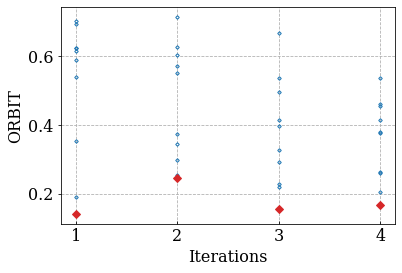

In [14]:
import json
from matplotlib.ticker import MaxNLocator
from  matplotlib import rcParams
from matplotlib import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt

rcParams['xtick.direction'] = 'in'
rcParams['axes.grid'] = True
rcParams['grid.linestyle'] = '--'
rcParams['markers.fillstyle'] = 'none'
rcParams['axes.prop_cycle'] = cycler(
    'linestyle', ["-", "--"]
)

# enable usetex by setting it to True if LaTeX is installed
rcParams['text.usetex'] = False
rcParams['font.size'] = 16
rcParams['font.family'] = 'serif'

logfilename = opt.logdir + "calibration.log"
with open(logfilename, "r") as filename:
    log = filename.readlines()
    

options = json.loads(log[7])

goal_function = []
batch = 0
batch_size = options["popsize"]


eval = 0
for line in log[9:]:
    if line[0] == "{":
        if not eval % batch_size:
            batch = eval // batch_size
            goal_function.append([])
        eval += 1
        point = json.loads(line)
        if 'goal' in point.keys():
            goal_function[batch].append(point['goal'])

# Clean unfinished batch
if len(goal_function[-1])<batch_size:
    goal_function.pop(-1)

fig, ax = plt.subplots(1)
means = []
bests = []
for ii in range(len(goal_function)):
    means.append(np.mean(np.array(goal_function[ii])))
    bests.append(np.min(np.array(goal_function[ii])))
    for pt in goal_function[ii]:
        ax.plot(ii+1, pt, color='tab:blue', marker="D", markersize=2.5, linewidth=0)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('ORBIT')
ax.set_xlabel('Iterations')
ax.plot(
    range(1, len(goal_function)+1), bests, color="tab:red", marker="D",
    markersize=5.5, linewidth=0, fillstyle='full'
)
